<a href="https://colab.research.google.com/github/NathaliL/Recidivism-Prediction/blob/main/Modified_COMPAS_Recidivism_BERT_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="center">BERT tutorial: Classify Recidivism using COMPAS dataset</h2>

In [4]:
!pip install transformers scikit-learn datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import load_dataset
from sklearn.model_selection import KFold


<h4>Load and preprocess the dataset from Hugging Face</h4>

In [6]:
# Load and inspect the dataset from Hugging Face
dataset = load_dataset('imodels/compas-recidivism')
df = dataset['train'].to_pandas()

# Display the first few rows to check the column names
print(df.head())
print(df.columns)



texts = df['age'].astype(str).tolist()  #  text column name
labels = df['is_recid']  #  'is_recid' is the column containing labels

print(texts[:5])
print(labels[:5])



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4937 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1235 [00:00<?, ? examples/s]

    age  priors_count  days_b_screening_arrest  c_jail_time  juv_fel_count  \
0  40.0           0.0                     -1.0          0.0            0.0   
1  25.0           1.0                     -1.0          1.0            0.0   
2  36.0          11.0                     -1.0          2.0            0.0   
3  23.0           1.0                     -1.0          0.0            0.0   
4  29.0           0.0                      0.0         -1.0            0.0   

   juv_other_count  juv_misd_count  c_charge_degree:F  c_charge_degree:M  \
0              0.0             0.0                0.0                1.0   
1              0.0             0.0                1.0                0.0   
2              0.0             0.0                0.0                1.0   
3              0.0             1.0                0.0                1.0   
4              0.0             0.0                0.0                1.0   

   race:African-American  ...  race:Caucasian  race:Hispanic  \
0         

In [9]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [10]:
def get_embeddings(text_list):
    embeddings = []
    for text in text_list:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())
    return np.vstack(embeddings)

<h4>Generate embeddings for the entire dataset</h4>

In [11]:
embeddings = get_embeddings(texts)

<h4>Split the data into training and test sets</h4>

In [15]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

<h4>Train the Logistic Regression classifier</h4>

In [16]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

<h4>Predict and evaluate the classifier</h4>

In [13]:
#y_pred = clf.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#precision = precision_score(y_test, y_pred, average='binary')
#recall = recall_score(y_test, y_pred, average='binary')
#f1 = f1_score(y_test, y_pred, average='binary')

#print(f"Accuracy: {accuracy}")
#print(f"Precision: {precision}")
#print(f"Recall: {recall}")
#print(f"F1 Score: {f1}")

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = embeddings
y = labels  # Labels: 'is_recid' column


# Define a function for performing K-Fold Cross-Validation
def perform_k_fold_cv(log_reg_model, X, y, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        log_reg_model.fit(X_train, y_train)
        predictions = log_reg_model.predict(X_val)

        accuracy_scores.append(accuracy_score(y_val, predictions))
        precision_scores.append(precision_score(y_val, predictions, average='binary'))
        recall_scores.append(recall_score(y_val, predictions, average='binary'))
        f1_scores.append(f1_score(y_val, predictions, average='binary'))

    return accuracy_scores, precision_scores, recall_scores, f1_scores

# Initialize the logistic regression model (use a different variable name)
log_reg_model = LogisticRegression(max_iter=1000)

# Perform K-Fold Cross-Validation for K=5 and K=10
acc_k5, prec_k5, recall_k5, f1_k5 = perform_k_fold_cv(log_reg_model, X, y, 5)
acc_k10, prec_k10, recall_k10, f1_k10 = perform_k_fold_cv(log_reg_model, X, y, 10)

# Print the results
print("K=5 Accuracy:", acc_k5)
print("K=5 Precision:", prec_k5)
print("K=5 Recall:", recall_k5)
print("K=5 F1 Score:", f1_k5)

print("K=10 Accuracy:", acc_k10)
print("K=10 Precision:", prec_k10)
print("K=10 Recall:", recall_k10)
print("K=10 F1 Score:", f1_k10)

K=5 Accuracy: [0.5981781376518218, 0.5850202429149798, 0.5612968591691996, 0.5785207700101317, 0.5663627152988855]
K=5 Precision: [0.5694915254237288, 0.5863539445628998, 0.5373406193078324, 0.5647668393782384, 0.5367132867132867]
K=5 Recall: [0.7014613778705637, 0.560081466395112, 0.6223628691983122, 0.6659877800407332, 0.6531914893617021]
K=5 F1 Score: [0.6286248830682881, 0.5729166666666666, 0.5767350928641252, 0.611214953271028, 0.5892514395393473]
K=10 Accuracy: [0.6072874493927125, 0.5890688259109311, 0.6052631578947368, 0.5910931174089069, 0.5506072874493927, 0.5728744939271255, 0.5890688259109311, 0.5679513184584178, 0.5578093306288032, 0.5578093306288032]
K=10 Precision: [0.5733333333333334, 0.5655172413793104, 0.583969465648855, 0.5850340136054422, 0.5364963503649635, 0.5358361774744027, 0.5870307167235495, 0.5435540069686411, 0.5038167938931297, 0.5543859649122806]
K=10 Recall: [0.7226890756302521, 0.6804979253112033, 0.6401673640167364, 0.6825396825396826, 0.607438016528925

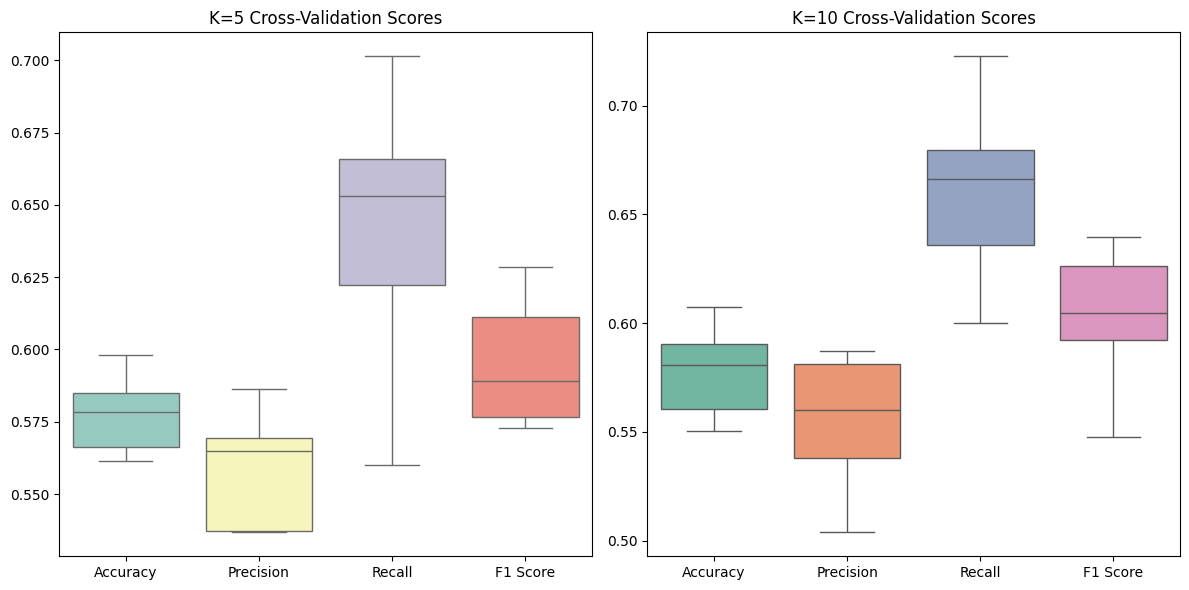

In [19]:
# Create box plots for K=5
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=[acc_k5, prec_k5, recall_k5, f1_k5], palette="Set3")
plt.xticks([0, 1, 2, 3], ['Accuracy', 'Precision', 'Recall', 'F1 Score'])
plt.title('K=5 Cross-Validation Scores')

# Create box plots for K=10
plt.subplot(1, 2, 2)
sns.boxplot(data=[acc_k10, prec_k10, recall_k10, f1_k10], palette="Set2")
plt.xticks([0, 1, 2, 3], ['Accuracy', 'Precision', 'Recall', 'F1 Score'])
plt.title('K=10 Cross-Validation Scores')

plt.tight_layout()
plt.show()

Label distribution: {0: 2532, 1: 2405}


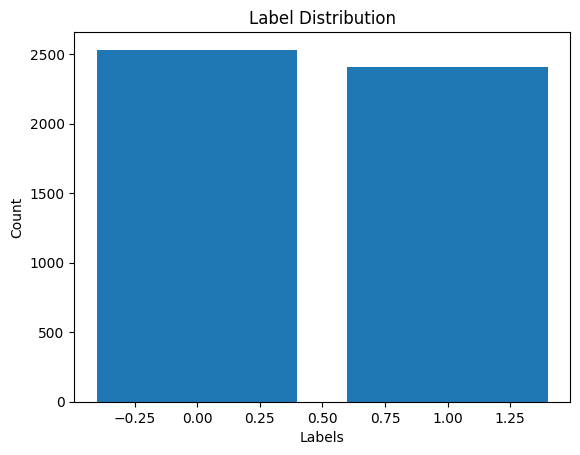

In [14]:
import numpy as np

# Check for class distribution in labels
unique, counts = np.unique(y, return_counts=True)
print("Label distribution:", dict(zip(unique, counts)))

# Plot the distribution (optional, for visualization)
import matplotlib.pyplot as plt

plt.bar(unique, counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

In [29]:
!git config --global user.email "nathali.20210422@iit.ac.lk"
!git config --global user.name "NathaliL"

# Step 1: Clone the repository
!git clone https://github.com/NathaliL/Recidivism-Prediction

# Step 2: Change directory to the cloned repository
%cd Recidivism-Prediction

# Step 3: Make changes to your notebook (this is done manually in the Colab UI)

# Step 4: Add, commit, and push changes
!git add BERT Recidvism using NIJ Dataset.ipynb
!git commit -m "Updated notebook with new changes"
!git push origin main

Cloning into 'Recidivism-Prediction'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 26 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 1.00 MiB | 1.88 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/Recidivism-Prediction/Recidivism-Prediction/Recidivism-Prediction
fatal: pathspec 'BERT' did not match any files
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address


In [19]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [20]:
print(type(model))

<class 'transformers.models.bert.modeling_bert.BertModel'>


In [23]:
print(model.__class__.__name__)

BertModel


In [24]:
print(type(model))

<class 'transformers.models.bert.modeling_bert.BertModel'>
